# crypto_ml nootebook
Application using machine learning to predict cryptocurrency prices from Binance Exchange API.
App also allow to simulate trading based on predicted moves.


### Project design in form CRISP-DM metodology 
1. Business Understanding
2. Data Understanding
3. Data Preparation 
4. Modeling
5. Evaluation
6. Deployment

### Requirements
Requests - allows you to send HTTP/1.1 requests extremely easily. There’s no need to manually add query strings to your URLs, or to form-encode your POST data. Keep-alive and HTTP connection pooling are 100% automatic, thanks to urllib3.

https://docs.python-requests.org/en/master/

Pandas - open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

https://pandas.pydata.org/docs/

NumPy - the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.

https://numpy.org/doc/

Matplotlib - comprehensive library for creating static, animated, and interactive visualizations in Python.

https://matplotlib.org/

Scikit-learn - open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

https://scikit-learn.org/stable/index.html

In [65]:
# pip install requests 
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install sklearn

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### 1. Business Understaning
Scenario: Let's assume we want to invest in cryptocurrencies. Our target is to build a model which predict for us next day price for the selected cryptocurrency. We also want to recieve information whether we should make a purchase or stay. 

To predict the price we will use linear regressions with machine learning. The data we use in our model will be taken from the public API provided by Binance Exchange https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md.

### 2. Data Understanding

In [66]:
#Binance API URLs

# Binance API endpoint
api_base_endpoint = "https://api.binance.com"

# All current prices 
api_current_price = api_base_endpoint + "/api/v3/ticker/price"

# 1000 days with prices for BTCUSDT (limit - records limit(max-1000), symbol-crypto pair symbols, interval - time interval)
api_historical_price = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"

In [67]:
#Use requests to get data from api as json
r_current_price = requests.get(api_current_price)
r_historical_price = requests.get(api_historical_price)

In [68]:
#Use pandas to read api with current prices
current_price = pd.read_json(r_current_price.text)

#Show all availabe pairs on Binance and thei prices (ETHBTC - ETH price in BTC)
current_price

,symbol,price
0,ETHBTC,0.072909
1,LTCBTC,0.006721
2,BNBBTC,0.011623
3,NEOBTC,0.002007
4,QTUMETH,0.006020
...,...,...
1425,TRXAUD,0.174800
1426,TRXEUR,0.112400
1427,VETTRY,1.793000
1428,SHIBUSDT,0.000026


In [69]:
#Use pandas to read api with historical prices selected pair
historical_price = pd.read_json(r_historical_price.text)

#Show all records for the selected pair and time interval
historical_price

,0,1,2,3,4,5,6,7,8,9,10,11
0,1534291200000,6188.08,6609.0,6172.11,6267.16,68806.687026,1534377599999,4.391090e+08,329413,37144.042168,2.370776e+08,0
1,1534377600000,6265.27,6480.0,6205.60,6311.75,48515.254618,1534463999999,3.077556e+08,228942,26023.549007,1.651237e+08,0
2,1534464000000,6316.00,6585.0,6285.40,6584.49,57851.610803,1534550399999,3.744724e+08,296730,32407.884552,2.098314e+08,0
3,1534550400000,6579.04,6620.0,6288.00,6387.96,53742.322172,1534636799999,3.459640e+08,276121,29469.810485,1.898089e+08,0
4,1534636800000,6387.96,6541.0,6300.00,6477.53,45190.847994,1534723199999,2.892720e+08,190758,25368.613272,1.624057e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1620259200000,57436.11,58360.0,55200.00,56393.68,70181.671908,1620345599999,3.992290e+09,2459881,34248.899643,1.949210e+09,0
996,1620345600000,56393.68,58650.0,55241.63,57314.75,74542.747829,1620431999999,4.239374e+09,2361692,36877.602566,2.097609e+09,0
997,1620432000000,57315.49,59500.0,56900.00,58862.05,69709.906028,1620518399999,4.079554e+09,2311378,34329.699156,2.009443e+09,0
998,1620518400000,58866.53,59300.0,56235.66,58240.84,69806.119910,1620604799999,4.043553e+09,2170139,34301.050457,1.987960e+09,0


The data presented may be incomprehensible, but we have information about each column from the Binance documentation :

  **0**  1499040000000,      // Open time \
  **1**  "0.01634790",       // Open \
  **2**  "0.80000000",       // High \
  **3**  "0.01575800",       // Low \
  **4**  "0.01577100",       // Close \
  **5**  "148976.11427815",  // Volume \
  **6**  1499644799999,      // Close time \
  **7**  "2434.19055334",    // Quote asset volume \
  **8**  308,                // Number of trades \
  **9**  "1756.87402397",    // Taker buy base asset volume \
  **10** "28.46694368",      // Taker buy quote asset volume \
  **11** "17928899.62484339" // Ignore. \
  
In our model, we will only need columns in the range 0-5

### 2. Data Preparing

In [70]:
#Delete columns in the range 6-11
del_columns = historical_price.iloc[:,6:]
historical_price_df = historical_price.drop(del_columns, axis=1)

#Rename columns
historical_price_df = historical_price_df.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close', 5:'Volume'})

#Change time from 'ns' to datetime 
historical_price_df['Open time'] = pd.to_datetime(historical_price_df['Open time'], unit="ms")

#Set time coulmn as index
historical_price_df = historical_price_df.set_index('Open time')

historical_price_df

,Open,High,Low,Close,Volume
Open time,,,,,
2018-08-15,6188.08,6609.0,6172.11,6267.16,68806.687026
2018-08-16,6265.27,6480.0,6205.60,6311.75,48515.254618
2018-08-17,6316.00,6585.0,6285.40,6584.49,57851.610803
2018-08-18,6579.04,6620.0,6288.00,6387.96,53742.322172
2018-08-19,6387.96,6541.0,6300.00,6477.53,45190.847994
...,...,...,...,...,...
2021-05-06,57436.11,58360.0,55200.00,56393.68,70181.671908
2021-05-07,56393.68,58650.0,55241.63,57314.75,74542.747829
2021-05-08,57315.49,59500.0,56900.00,58862.05,69709.906028


<AxesSubplot:xlabel='Open time'>

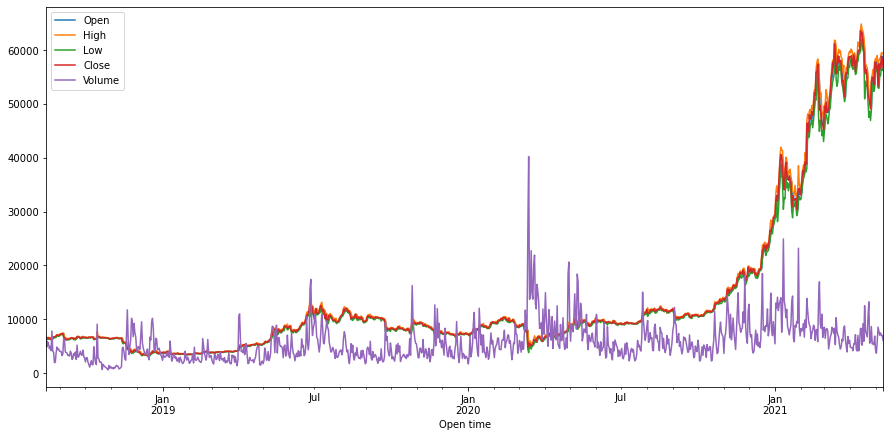

In [71]:
#Show how data looks on chart
plot_price = historical_price_df.copy()
plot_price['Volume'] = plot_price['Volume']/10 #Change Volume size to chart more readable 
plot_price.plot(figsize=(15,7))

### Linear regression 

**Hypothesis** 
$$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n}$$ \
$$y_{m} = next\_day\_price $$ \
$\;\;x_{n}$ - values \
$\;\;y$ - “output” variable/“target”'variable \
$\;\;n$ - number of features \
$\;\;m$ - number of days 

First model is inspired by https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/

$$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2}$$ 

Where: \
$\;\;x_{1}$ - close mean value for 3 days \
$\;\;x_{2}$ - close mean value for 9 days \
$\;\;y$ - next day close price created from each next day record in our data (close column) 


Second model 
    $$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3} + \theta_{4}x_{4}$$ \
Where: \
$\;\;x_{1}$ - Open price \
$\;\;x_{2}$ - Close price \
$\;\;x_{3}$ - Low price \
$\;\;x_{4}$ - Price price \
$\;\;y$ - next day mean price created from each next day mean price (open, close, low, high) record in our data

In [72]:
close_predict = historical_price_df.copy()

#close mean value for 3 days
close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()

#close mean value for 9 days 
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()

#next day close price
close_predict['next_day_close_price'] = close_predict['Close'].shift(-1)

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-08-15,6188.08,6609.0,6172.11,6267.16,68806.687026,NaN,NaN,6311.75
2018-08-16,6265.27,6480.0,6205.60,6311.75,48515.254618,NaN,NaN,6584.49
2018-08-17,6316.00,6585.0,6285.40,6584.49,57851.610803,6387.800000,NaN,6387.96
2018-08-18,6579.04,6620.0,6288.00,6387.96,53742.322172,6428.066667,NaN,6477.53
2018-08-19,6387.96,6541.0,6300.00,6477.53,45190.847994,6483.326667,NaN,6254.84
...,...,...,...,...,...,...,...,...
2021-05-06,57436.11,58360.0,55200.00,56393.68,70181.671908,55676.600000,56074.806667,57314.75
2021-05-07,56393.68,58650.0,55241.63,57314.75,74542.747829,57048.180000,56349.087778,58862.05
2021-05-08,57315.49,59500.0,56900.00,58862.05,69709.906028,57523.493333,56938.760000,58240.84


In [73]:
#droping rows with NaN 
close_predict = close_predict.dropna()

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-08-23,6362.57,6576.99,6342.28,6525.01,40358.166825,6455.300000,6405.514444,6681.64
2018-08-24,6525.00,6725.00,6440.50,6681.64,38305.675322,6522.513333,6451.567778,6733.64
2018-08-25,6686.98,6789.00,6650.61,6733.64,19220.505929,6646.763333,6498.444444,6700.00
2018-08-26,6733.64,6775.27,6568.00,6700.00,20107.297208,6705.093333,6511.278889,6908.64
2018-08-27,6700.00,6940.51,6646.50,6908.64,37747.078747,6780.760000,6569.132222,7076.11
...,...,...,...,...,...,...,...,...
2021-05-05,53205.05,58069.82,52900.00,57436.11,77263.923439,55935.170000,55921.283333,56393.68
2021-05-06,57436.11,58360.00,55200.00,56393.68,70181.671908,55676.600000,56074.806667,57314.75
2021-05-07,56393.68,58650.00,55241.63,57314.75,74542.747829,57048.180000,56349.087778,58862.05


In [74]:
#copy historical prices without Volume column
mean_predict = historical_price_df[['Open', 'High', 'Low', 'Close']].copy()

#create column for mean value
mean_predict['mean'] = 0

#change he value in the column 'mean' to mean price of the Open, High, Low and Close records
for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
#next day mean price
mean_predict['next_day_mean_price'] = mean_predict['mean'].shift(-1)

#droping rows with NaN 
mean_predict = mean_predict.dropna()

mean_predict  

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,next_day_mean_price
Open time,,,,,,
2018-08-15,6188.08,6609.00,6172.11,6267.16,6309.0875,6315.6550
2018-08-16,6265.27,6480.00,6205.60,6311.75,6315.6550,6442.7225
2018-08-17,6316.00,6585.00,6285.40,6584.49,6442.7225,6468.7500
2018-08-18,6579.04,6620.00,6288.00,6387.96,6468.7500,6426.6225
2018-08-19,6387.96,6541.00,6300.00,6477.53,6426.6225,6370.5925
...,...,...,...,...,...,...
2021-05-05,53205.05,58069.82,52900.00,57436.11,55402.7450,56847.4475
2021-05-06,57436.11,58360.00,55200.00,56393.68,56847.4475,56900.0150
2021-05-07,56393.68,58650.00,55241.63,57314.75,56900.0150,58144.3850


### 3. Modeling
To create and evaluate the model we will use Sckit-learn library which will do all the linear regression calculations for us.
We will train two our models, compare them and choose a more exact onet.

In [75]:
#data
X = close_predict[['close_3', 'close_9']]

#target values
y = close_predict['next_day_close_price']

#split data 80% - training data; 20% - test data
split = 0.8
split = int(split*len(close_predict))

#training data
X_train = X[:split]
y_train = y[:split]

#test data
X_test = X[split:]
y_test = y[split:]

#import linear regression model from Scikit-learn
model = LinearRegression()

#fit linear model
model.fit(X_train, y_train)

LinearRegression()

In [76]:
#use model to predict test data
predicted_price = model.predict(X_test)

#create dataframe with predicted data
predicted_price_df = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])
predicted_price_df

,Price
Open time,
2020-10-23,13077.411431
2020-10-24,13170.460001
2020-10-25,13149.644899
2020-10-26,13157.567852
2020-10-27,13316.146366
...,...
2021-05-05,55589.981768
2021-05-06,55234.428066
2021-05-07,56859.143670


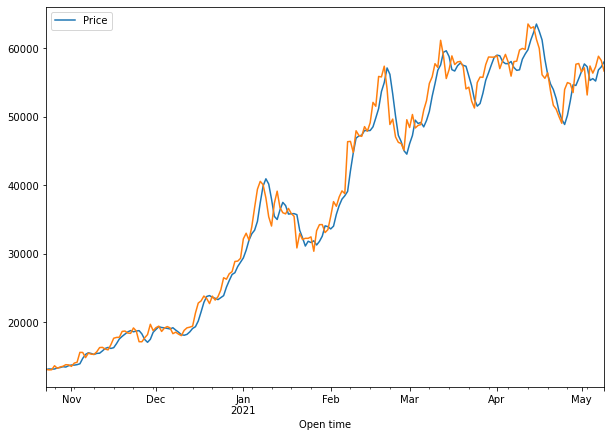

In [78]:
#plot dataframe with predicted data
predicted_price_df.plot(figsize=(10,7))
y_test.plot()
plt.show()

In [90]:
#return the coefficient of prediction
score = model.score(X[split:], y[split:])*100
print(f"Predict score: {float(score.round(2))}" )

print(f"Crypto Price (y) = {model.intercept_.round(2)} + {model.coef_[0].round(2)} * 3 Days Moving Average (x1) \
+ {model.coef_[1].round(2)} * 9 Days Moving Average (x2)")

Predict score: 98.44
Crypto Price (y) = 69.69 + 1.23 * 3 Days Moving Average (x1) + -0.24 * 9 Days Moving Average (x2)


In [9]:
close_predict = historical_price.copy()

close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()
close_predict = close_predict.dropna()

close_predict['predicted_crypto_price'] = model.predict(close_predict[['close_3', 'close_9']])

close_predict.tail()

,Open,High,Low,Close,Volume,close_3,close_9,predicted_crypto_price
Open time,,,,,,,,
2021-05-05,53205.05,58069.82,52900.00,57436.11,77263.923439,55935.170000,55921.283333,55606.405309
2021-05-06,57436.11,58360.00,55200.00,56393.68,70181.671908,55676.600000,56074.806667,55250.467442
2021-05-07,56393.68,58650.00,55241.63,57314.75,74542.747829,57048.180000,56349.087778,56876.430432
2021-05-08,57315.49,59500.00,56900.00,58862.05,69709.906028,57523.493333,56938.760000,57320.812983
2021-05-09,58866.53,59300.00,57575.00,57962.39,28453.465298,58046.396667,56968.551111,57958.700923


In [10]:
mean_predict = historical_price[['Open', 'High', 'Low', 'Close']].copy()

mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['next_day_price'] = mean_predict['mean'].shift(-1)
mean_predict = mean_predict.dropna()

mean_predict

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,next_day_price
Open time,,,,,,
2018-08-14,6248.25,6250.33,5880.00,6188.08,6141.6650,6309.0875
2018-08-15,6188.08,6609.00,6172.11,6267.16,6309.0875,6315.6550
2018-08-16,6265.27,6480.00,6205.60,6311.75,6315.6550,6442.7225
2018-08-17,6316.00,6585.00,6285.40,6584.49,6442.7225,6468.7500
2018-08-18,6579.04,6620.00,6288.00,6387.96,6468.7500,6426.6225
...,...,...,...,...,...,...
2021-05-04,57169.39,57200.00,53046.69,53200.01,55154.0225,55402.7450
2021-05-05,53205.05,58069.82,52900.00,57436.11,55402.7450,56847.4475
2021-05-06,57436.11,58360.00,55200.00,56393.68,56847.4475,56900.0150


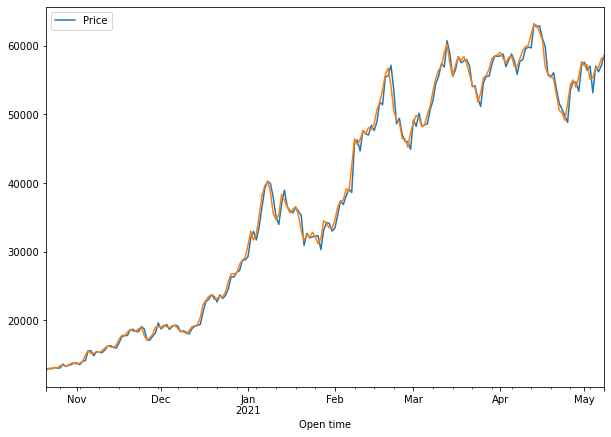

Predict score: 99.67


In [11]:
X = mean_predict[['Open', 'High', 'Low', 'Close']]
y = mean_predict['next_day_price']

t = 0.8
t = int(t*len(mean_predict))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

score = model.score(X[t:], y[t:])*100
print(f"Predict score: {float(score.round(2))}" )

In [12]:
mean_predict = historical_price.copy()

mean_predict = mean_predict.iloc[:,0:4]
mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['predicted_crypto_price'] = model.predict(mean_predict[['Open', 'High', 'Low', 'Close']])
mean_predict

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2018-08-14,6248.25,6250.33,5880.00,6188.08,6141.6650,6178.048663
2018-08-15,6188.08,6609.00,6172.11,6267.16,6309.0875,6287.903259
2018-08-16,6265.27,6480.00,6205.60,6311.75,6315.6550,6322.687032
2018-08-17,6316.00,6585.00,6285.40,6584.49,6442.7225,6576.519644
2018-08-18,6579.04,6620.00,6288.00,6387.96,6468.7500,6398.064928
...,...,...,...,...,...,...
2021-05-05,53205.05,58069.82,52900.00,57436.11,55402.7450,57059.358534
2021-05-06,57436.11,58360.00,55200.00,56393.68,56847.4475,56232.791514
2021-05-07,56393.68,58650.00,55241.63,57314.75,56900.0150,57091.459803


In [13]:
mean_predict['move'] = np.where(
    mean_predict['mean'] < mean_predict['predicted_crypto_price'], "Buy", "Stay"
)
mean_predict.tail(1)

,Open,High,Low,Close,mean,predicted_crypto_price,move
Open time,,,,,,,
2021-05-09,58866.53,59300.0,57575.0,57962.39,58425.98,57826.479633,Stay


In [14]:
money = 10 
money_spend = 0
buys = 0
bought_coins = 0
for i in range(len(mean_predict)):
    if mean_predict['move'].iloc[i] == 'Buy':
        buys +=1
        bought_coins += money / mean_predict['mean'].iloc[i]
        money_spend += money


coin_price = mean_predict['mean'].iloc[-1]

print(f"Buys number: {buys}\nBought coins: {bought_coins}\nMoney spend: {money_spend}\nCurrent coin price: {coin_price}")
print()
fortune = bought_coins*coin_price
print(f'Fortune: {fortune.round(2)}\nProfit: {(fortune-money_spend).round(2)}')

Buys number: 543
Bought coins: 0.667883577205751
Money spend: 5430
Current coin price: 58425.979999999996

Fortune: 39021.75
Profit: 33591.75


In [37]:
money = 10
money_spend = 10
buys = 0
sales = 0
bought_coins = 0
for i in range(len(mean_predict)):
    if mean_predict['move'].iloc[i] == 'Buy':
        buys += 1
        bought_coins += money / mean_predict['mean'].iloc[i]
        money_spend += money
    else:
        sales += 1
        bought_coins -= money / mean_predict['mean'].iloc[i]
        money_spend -= money 

coin_price = mean_predict['mean'].iloc[-1]

print(f"Buys number: {buys}\nSales numebr: {sales}\nBuyed coins: {bought_coins}\nMoney spend: {money_spend}\nCurrent coin price: {coin_price}")
print()
fortune = bought_coins*coin_price
print(f'Fortune: {fortune.round(2)}\nProfit: {(fortune-money_spend).round(2)}')

Buys number: 527
Sales numebr: 473
Buyed coins: 0.05499223563870262
Money spend: 550
Current coin price: 3914.6475

Fortune: 215.28
Profit: -334.72


In [16]:
def buys_sales_simulator_df(money_buys=10, money_sales=10):
    money_spend = 0
    buys = 0
    bought_coins = 0
    sales = 0
    for i in range(len(mean_predict)):
        if mean_predict['move'].iloc[i] == 'Buy':
            buys +=1
            bought_coins += money_buys / mean_predict['mean'].iloc[i]
            money_spend += money_buys
        else:
            sales += 1
            bought_coins -= money_sales / mean_predict['mean'].iloc[i]
            money_spend -= money_sales 
    coin_price = mean_predict['mean'].iloc[-1]
    fortune = (bought_coins * coin_price).round(2)
    profit = (fortune - money_spend).round(2)
    rate_of_return = ((profit / money_spend) * 100).round(2)
    df = pd.DataFrame(data={
        'Money for buys': money_buys,
        'Money for sales': money_sales,
        'Buys number': buys,
        'Sales number': sales,
        'Bought coins': bought_coins,
        'Money spend': money_spend,
        'Current coin price': coin_price,
        'Fortune': fortune,
        'profit': profit,
        'rate of return': rate_of_return,
    }, index=[0])
    return df

In [17]:
buys_sales_simulator_df(10,10)

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
0,10,10,543,457,0.096492,860,58425.98,5637.64,4777.64,555.54


In [18]:
# df = pd.DataFrame(data=buys_sales_simulator_df(1,1))
# for i in range(1,101):
#     for j in range(101):
#         df = df.append(pd.DataFrame(data=buys_sales_simulator_df(i,j)))
# df = df.reset_index()
# df = df.drop([0])
# df = df.drop('index', axis=1)
# df.to_csv('buys_sales_simulation_df_BTCUSDT_1d.csv', index=False)
# df

In [19]:
df = pd.read_csv('buys_sales_simulation_df_BTCUSDT_1m.csv')
df['Minus number'] = np.where(df['Money spend'] <0, None, 0)
df = df.dropna()
df = df.drop('Minus number', axis=1)
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit
9998,99,100,505,495,0.008807,495,57351.7975,505.12,10.12


In [20]:
df = pd.read_csv('buys_sales_simulation_df_BTCUSDT_1h.csv')
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit
9999,100,0,496,504,0.879223,49600,57491.1875,50547.57,947.57


In [21]:
df = pd.read_csv('buys_sales_simulation_df_BTCUSDT_1d.csv')
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit
9999,100,0,543,457,6.732396,54300,57758.7625,388854.88,334554.88


In [22]:
api_base_endpoint = "https://api.binance.com"
btc_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"
eth_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=ETHUSDT&interval=1d"
lsk_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=LSKUSDT&interval=1d"
ethbtc_api = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=ETHBTC&interval=1d"
r_btc = requests.get(btc_api)
r_eth = requests.get(eth_api)
r_lsk = requests.get(lsk_api)
r_ethbtc = requests.get(ethbtc_api)
btc_df = pd.read_json(r_btc.text)
eth_df = pd.read_json(r_eth.text)
lsk_df = pd.read_json(r_lsk.text)
ethbtc_df = pd.read_json(r_ethbtc.text)

In [23]:
def prepare_data(data):
    data = data.copy()
    del_columns = data.iloc[:,5:]
    data = data.drop(del_columns, axis=1)
    data = data.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close'})
    data['Open time'] = pd.to_datetime(data['Open time'], unit="ms")
    data = data.set_index('Open time')

    return data

In [24]:
btc_df = prepare_data(btc_df)
eth_df = prepare_data(eth_df)
lsk_df = prepare_data(lsk_df)
ethbtc_df = prepare_data(ethbtc_df)

,BTC,ETH,LSK,ETHBTC
Open time,,,,
2018-08-14,618.808,556.82,NaN,2250.40
2018-08-15,626.716,562.24,NaN,2241.80
2018-08-16,631.175,574.34,NaN,2271.20
2018-08-17,658.449,635.02,NaN,2412.00
2018-08-18,638.796,588.22,NaN,2302.20
...,...,...,...,...
2021-05-05,5743.611,7048.52,3095.15,3068.15
2021-05-06,5639.368,6979.46,3460.40,3094.05
2021-05-07,5731.475,6959.06,4523.15,3035.05


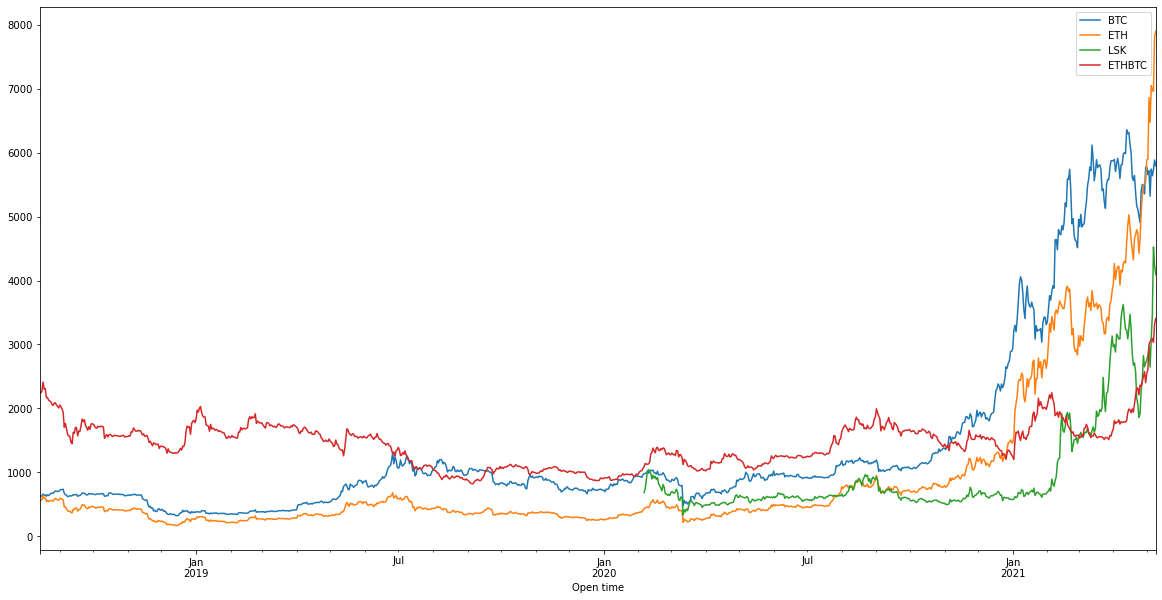

In [25]:
test_df = pd.DataFrame(data={'BTC':btc_df['Close'], 'ETH':eth_df['Close'],'LSK':lsk_df['Close'], 'ETHBTC':ethbtc_df['Close']})
test_df['BTC'] = test_df['BTC']/10
test_df['ETHBTC'] = test_df['ETHBTC']*50000
test_df['ETH'] = test_df['ETH']*2
test_df['LSK'] = test_df['LSK']*500

test_df.plot(figsize=(20,10))

test_df

In [26]:
test_df.corr()

,BTC,ETH,LSK,ETHBTC
BTC,1.000000,0.957871,0.838308,0.407530
ETH,0.957871,1.000000,0.877555,0.573062
LSK,0.838308,0.877555,1.000000,0.632163
ETHBTC,0.407530,0.573062,0.632163,1.000000


C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


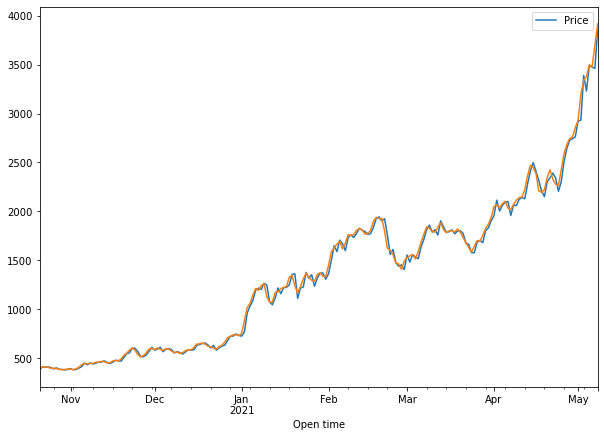

Predict score: 99.6


In [27]:
mean_predict = eth_df[['Open', 'High', 'Low', 'Close']].copy()

mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['next_day_price'] = mean_predict['mean'].shift(-1)
mean_predict = mean_predict.dropna()

mean_predict

X = mean_predict[['Open', 'High', 'Low', 'Close']]
y = mean_predict['next_day_price']

t = 0.8
t = int(t*len(mean_predict))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

score = model.score(X[t:], y[t:])*100
print(f"Predict score: {float(score.round(2))}" )

In [28]:
mean_predict = eth_df.copy()

mean_predict = mean_predict.iloc[:,0:4]
mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['predicted_crypto_price'] = model.predict(mean_predict[['Open', 'High', 'Low', 'Close']])
mean_predict

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2018-08-14,283.81,283.81,250.00,278.41,274.0075,276.299014
2018-08-15,278.47,304.45,276.30,281.12,285.0850,281.549709
2018-08-16,281.46,298.60,277.55,287.17,286.1950,286.825665
2018-08-17,286.84,318.00,285.00,317.51,301.8375,315.197195
2018-08-18,317.51,321.33,281.79,294.11,303.6850,293.738086
...,...,...,...,...,...,...
2021-05-05,3239.01,3549.34,3200.23,3524.26,3378.2100,3491.644002
2021-05-06,3524.33,3605.40,3376.47,3489.73,3498.9825,3472.925222
2021-05-07,3489.74,3587.00,3353.23,3479.53,3477.3750,3461.755573


In [29]:
mean_predict['move'] = np.where(
    mean_predict['predicted_crypto_price'].shift(1) < mean_predict['predicted_crypto_price'], "Buy", "Stay"
)
mean_predict.tail()

,Open,High,Low,Close,mean,predicted_crypto_price,move
Open time,,,,,,,
2021-05-05,3239.01,3549.34,3200.23,3524.26,3378.2100,3491.644002,Buy
2021-05-06,3524.33,3605.40,3376.47,3489.73,3498.9825,3472.925222,Stay
2021-05-07,3489.74,3587.00,3353.23,3479.53,3477.3750,3461.755573,Stay
2021-05-08,3479.79,3958.33,3449.27,3910.26,3699.4125,3868.174181,Buy
2021-05-09,3910.26,3983.65,3815.02,3949.66,3914.6475,3927.552262,Buy


In [30]:
# df = pd.DataFrame(data=buys_sales_simulator_df(1,1))
# for i in range(1,101):
#     for j in range(101):
#         df = df.append(pd.DataFrame(data=buys_sales_simulator_df(i,j)))
# df = df.reset_index()
# df = df.drop([0])
# df = df.drop('index', axis=1)
# df.to_csv('buys_sales_simulation_df_ETHUSDT_1d.csv', index=False)
# df

In [31]:
df = pd.read_csv('buys_sales_simulation_df_ETHUSDT_1d.csv')
df['Minus number'] = np.where(df['Money spend'] <0, None, 0)
df = df.dropna()
df = df.drop('Minus number', axis=1)
df.loc[df['profit'] == df['profit'].max()]

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
9999,100,0,526,474,228.44568,52600,2849.16,650878.29,598278.29,1137.41


In [32]:
t1,t2,t3 = test_df[:400], test_df[400:700], test_df[700:1000]

<AxesSubplot:xlabel='Open time'>

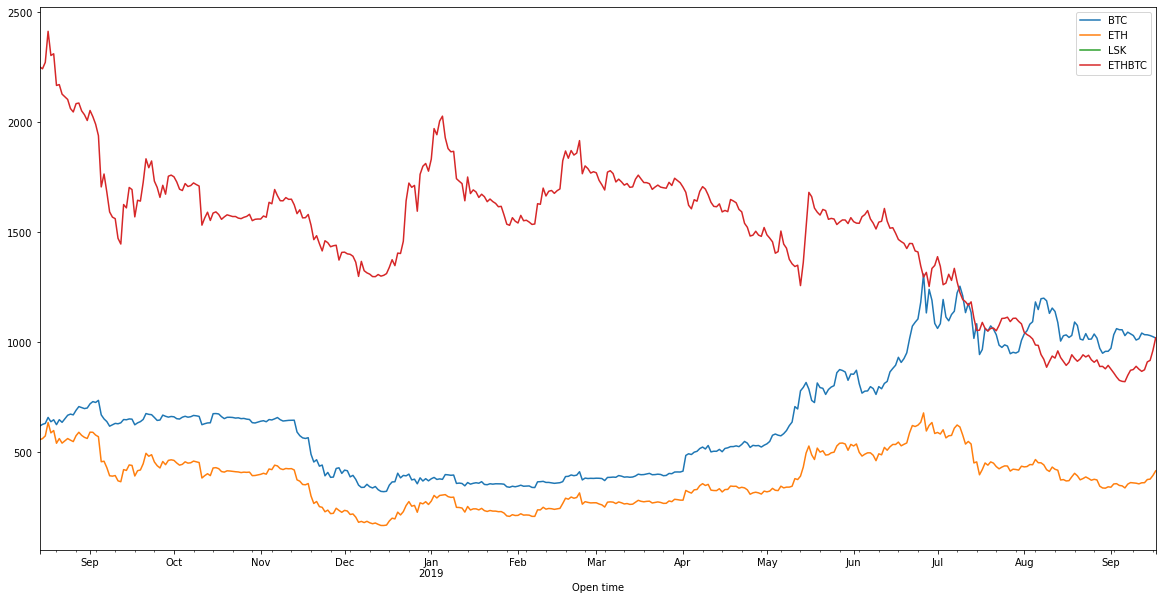

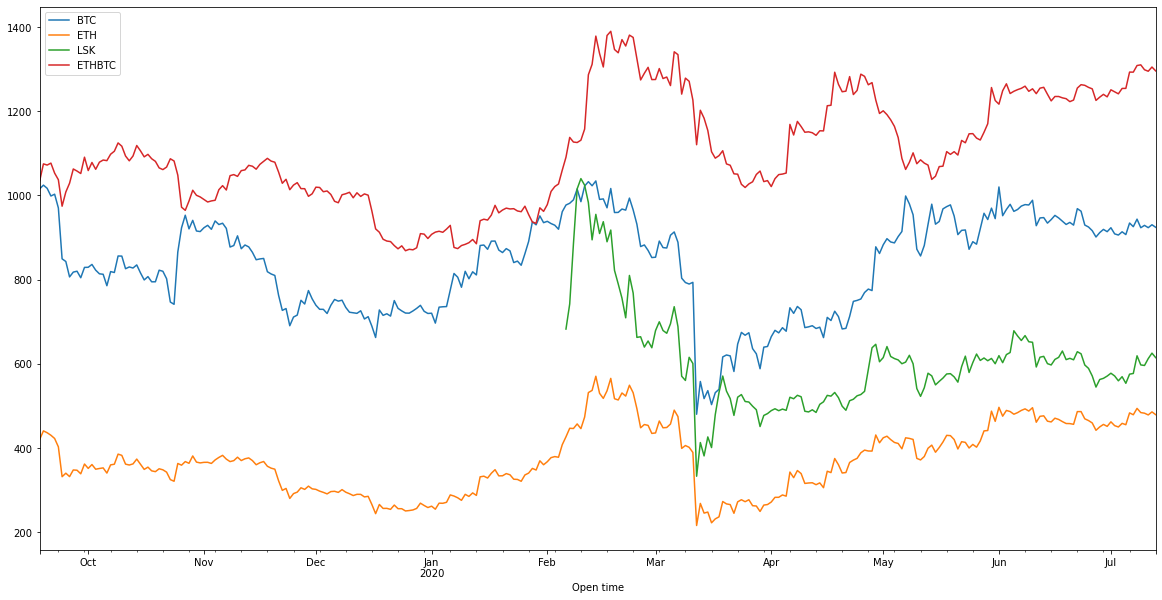

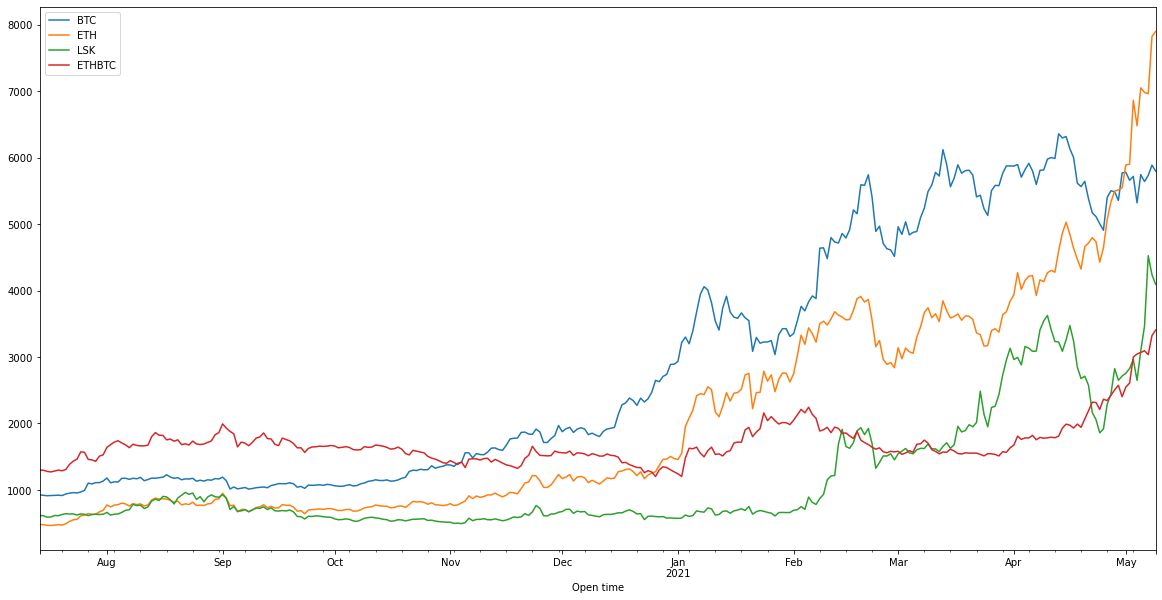

In [33]:
t1.plot(figsize=(20,10))
t2.plot(figsize=(20,10))
t3.plot(figsize=(20,10))

In [34]:
t1.corr()

,BTC,ETH,LSK,ETHBTC
BTC,1.000000,0.743587,NaN,-0.636328
ETH,0.743587,1.000000,NaN,0.018188
LSK,NaN,NaN,NaN,NaN
ETHBTC,-0.636328,0.018188,NaN,1.000000


In [35]:
t2.corr()

,BTC,ETH,LSK,ETHBTC
BTC,1.000000,0.849814,0.705375,0.356439
ETH,0.849814,1.000000,0.732601,0.791712
LSK,0.705375,0.732601,1.000000,0.474358
ETHBTC,0.356439,0.791712,0.474358,1.000000


In [36]:
t3.corr()

,BTC,ETH,LSK,ETHBTC
BTC,1.000000,0.932309,0.827795,0.435041
ETH,0.932309,1.000000,0.873298,0.712334
LSK,0.827795,0.873298,1.000000,0.579080
ETHBTC,0.435041,0.712334,0.579080,1.000000
